# Welcome to our Presentation

## Our team: Arif, Iliyan and Joseph

> WHO have asked us to create two models two predict the average life expectancy of a country. Our first model will be an **advanced model** that is going to use any relevant data required to produce the best possible prediction for life expectancy. Our second model will be a more **basic model** which will take ethical considerations and sensitive data will be omitted. We will explain how we made our models and give a demonstration in our presentation.

# Agenda
* **Exploratory data analysis** of the WHO life expectancy dataset.
* What data should we use as **features** in our life expectancy models?
* **Feature engineering**: Do we need to modify any of our features? How do we do this?
* **Create and analyse** the performance of our models.
* Discuss **ethical considerations** we made when deciding on the features of our models.
* A **demonstration** of the function that runs our models.

In [71]:
# Import the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.tools

# Exploring the WHO Life Expectancy Dataset

## Initial Exploration
> We began by exploring the WHO dataset. We checked that the dataset has no missing values and that the values in the columns are valid in terms of the metadata descriptions.

In [26]:
# First read the csv file
WHO = pd.read_csv("Life Expectancy Data.csv")

In [27]:
pd.set_option("display.max_columns", None)   # Display all the columns
WHO.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,97,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,97,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,67,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,92,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,94,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


##### Notes
* Economy Status is already partially one-hot-encoded. We will need to drop one of the two columns to avoid multicollinearity.
* Country and Region columns currently contain strings. We will need to either drop or feature engineer these columns.

In [29]:
# Count the nulls in the data
WHO.isnull().sum()

Country                        0
Region                         0
Year                           0
Infant_deaths                  0
Under_five_deaths              0
Adult_mortality                0
Alcohol_consumption            0
Hepatitis_B                    0
Measles                        0
BMI                            0
Polio                          0
Diphtheria                     0
Incidents_HIV                  0
GDP_per_capita                 0
Population_mln                 0
Thinness_ten_nineteen_years    0
Thinness_five_nine_years       0
Schooling                      0
Economy_status_Developed       0
Economy_status_Developing      0
Life_expectancy                0
dtype: int64

In [30]:
len(WHO.Country.unique())

179

In [31]:
len(WHO)/179

16.0

##### Notes
* The are no null values in our dataset
* There are 179 unique countries in our dataset (with 16 years worth of data)

In [33]:
# View the column details
WHO.describe().loc[['mean', 'std', 'min', 'max']]

,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
mean,2007.500000,30.363792,42.938268,192.251775,4.820882,84.292598,77.344972,25.032926,86.499651,86.271648,0.894288,11540.924930,36.675915,4.865852,4.899825,7.632123,0.206704,0.793296,68.856075
std,4.610577,27.538117,44.569974,114.910281,3.981949,15.995511,18.659693,2.193905,15.080365,15.534225,2.381389,16934.788931,136.485867,4.438234,4.525217,3.171556,0.405012,0.405012,9.405608
min,2000.000000,1.800000,2.300000,49.384000,0.000000,12.000000,10.000000,19.800000,8.000000,16.000000,0.010000,148.000000,0.080000,0.100000,0.100000,1.100000,0.000000,0.000000,39.400000
max,2015.000000,138.100000,224.900000,719.360500,17.870000,99.000000,99.000000,32.100000,99.000000,99.000000,21.680000,112418.000000,1379.860000,27.700000,28.600000,14.100000,1.000000,1.000000,83.800000


##### Notes
* Mininum and maximum values behave correctly when comparing to the metadata descriptions.
* Scaling will be required in feature engineering. For example, GDP_per_capita range is much larger than any other column.
* Mean and standard deviations seem to behave in a way one would expect.

## Exploring the correlations
> We split the columns into three categories and analyse the correlation with life expectancy: **Mortality**, **Health**, **Economy**

In [36]:
# Divide the columns into categories
mortality_cols = ['Infant_deaths', 'Under_five_deaths', 'Adult_mortality', 'Incidents_HIV', 'Life_expectancy']
health_cols = ['Alcohol_consumption', 'Hepatitis_B', 'Measles', 'BMI', 'Polio', 'Diphtheria',
               'Thinness_ten_nineteen_years', 'Thinness_five_nine_years', 'Life_expectancy']
economy_cols = ['GDP_per_capita', 'Population_mln', 'Schooling', 'Economy_status_Developed', 'Economy_status_Developing',
                'Life_expectancy']

### Mortality Columns

##### Notes
* The mortality columns are `infant deaths`, `under five deaths`, `adult mortality`, and `incidents HIV`.
* These columns generally have a **very high correlation** with life expectancy.
* We will likely use these columns as features in our models.

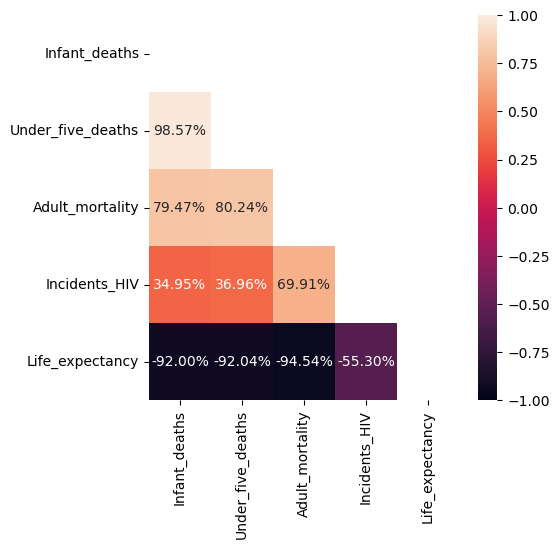

In [38]:
# Mortality correlation heatmap
plt.figure(figsize = (5,5))
sns.heatmap(WHO[mortality_cols].corr(),
            vmin = -1,
            vmax = 1,
            annot = True,
            fmt = '.2%',
            cmap = 'rocket',
            mask = np.triu(WHO[mortality_cols].corr()))
plt.show()

### Health Columns

##### Notes
* The health columns are `alcohol consumption`, `hepatitis B`, `measles`, `BMI`, `polio`, `diphtheria`, `thinness 10-19 years`, and `thinness 5-9 years`.
* These columns generally have **low-mid correlation** with life expectancy.
* We are unlikely to use most of these columns as features in our models.

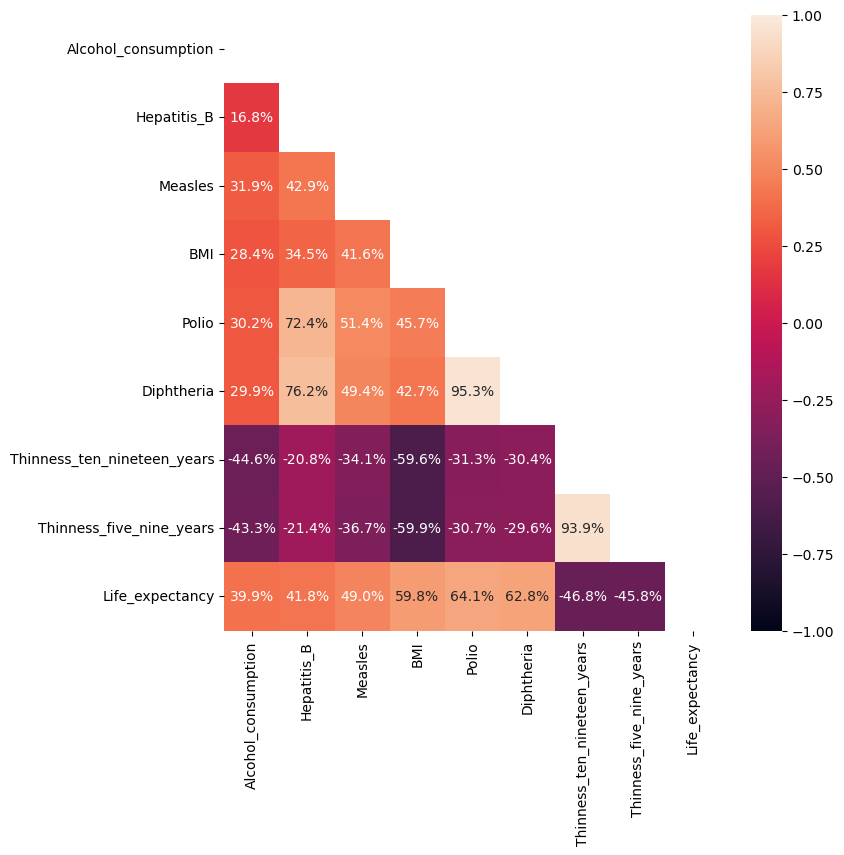

In [40]:
# Health correlation heatmap
plt.figure(figsize = (8,8))
sns.heatmap(WHO[health_cols].corr(),
            vmin = -1,
            vmax = 1,
            annot = True,
            fmt = '.1%',
            cmap = 'rocket',
            mask = np.triu(WHO[health_cols].corr()))
plt.show()

### Economy Columns

##### Notes
* The economy columns are `GDP per capita`, `population`, `schooling`, `economy status developed`, and `economy status developing`.
* These columns generally have **mid-high correlation** with life expectancy.
* `Population` has almost **no correlation** with life expectancy. We will definitely not use population in our models.
* We are likely to use some of these columns as features in our models.

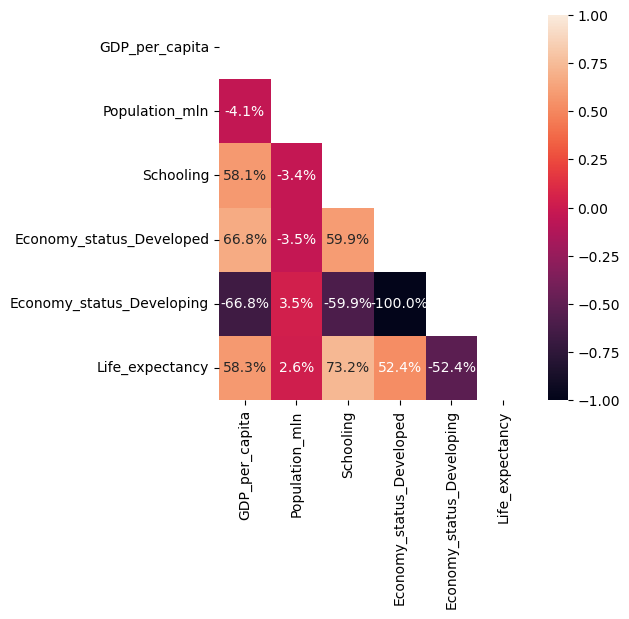

In [42]:
# Economy correlation heatmap
plt.figure(figsize = (5,5))
sns.heatmap(WHO[economy_cols].corr(),
            vmin = -1,
            vmax = 1,
            annot = True,
            fmt = '.1%',
            cmap = 'rocket',
            mask = np.triu(WHO[economy_cols].corr()))
plt.show()

## EDA Summary

**Mortality**: `infant deaths`, `under five deaths`, `adult mortality`, and `incidents HIV`
* The **mortality columns** generally have a **very high correlation** with life expectancy.
* We will likely use these columns as features in our models.

**Health**: `alcohol consumption`, `hepatitis B`, `measles`, `BMI`, `polio`, `diphtheria`, `thinness 10-19 years`, and `thinness 5-9 years`
* The **health columns** generally have a **low-mid correlation** with life expectancy.
* We are unlikely to use most of these columns as features in our models.

**Economy**: `GDP per capita`, `population`, `schooling`, `economy status developed`, and `economy status developing`.
* The **economy columns** generally have a **mid-high correlation** with life expectancy.
* We are likely to use some of these columns as features in our models.

In [45]:
# Preparing for Train-test splitting

feature_cols = list(WHO.columns)
feature_cols.remove('Life_expectancy')

X = WHO[feature_cols]
y = WHO['Life_expectancy']

In [46]:
feature_cols

['Country',
 'Region',
 'Year',
 'Infant_deaths',
 'Under_five_deaths',
 'Adult_mortality',
 'Alcohol_consumption',
 'Hepatitis_B',
 'Measles',
 'BMI',
 'Polio',
 'Diphtheria',
 'Incidents_HIV',
 'GDP_per_capita',
 'Population_mln',
 'Thinness_ten_nineteen_years',
 'Thinness_five_nine_years',
 'Schooling',
 'Economy_status_Developed',
 'Economy_status_Developing']

In [47]:
# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)